# Лабораторная работа 3

Обработка текстов.

Описание спортивных матчей (футольных, баскетбольных, хоккейных, волейбольных) с использованием специфичных терминов.

In [37]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy3
import math
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#### Преобразование данных, удаление стоп-слов

In [ ]:
nltk.download("stopwords")

stopWords = stopwords.words("russian")
stopWords.append("это")

morph = pymorphy3.MorphAnalyzer(lang='ru')

def delete_stop_words(text):
    return [ word for word in text if word not in stopWords ]

def format_data(text):
    fmtTextStr = re.sub(
        r'[^\w\s]', 
        ' ', 
        text.lower(), 
        flags=re.UNICODE
    )
    tokenTextArr = nltk.word_tokenize(fmtTextStr)
    cleanTextArr = delete_stop_words(tokenTextArr)

    return " ".join(cleanTextArr)

def get_normal_form_str(line):
    return " ".join([
        morph.parse(word)[0].normal_form for word in line.split() 
        if morph.parse(word)[0].normal_form not in stopWords
    ])

#### Чтение данных

In [39]:
def read_files(filename, format):
    i = 1
    dataArr = []
    while True:
        try:
            fd = open(filename + str(i) + format, encoding="utf-8")
        except Exception:
            break
        
        dataArr.append([i, fd.read()])
        
        fd.close()
        i += 1

    return dataArr

footballArr = read_files("./data/football_", ".txt")
basketballArr = read_files("./data/basketball_", ".txt")
hockeyArr = read_files("./data/hockey_", ".txt")
volleyballArr = read_files("./data/volleyball_", ".txt")

In [40]:
dfFootball = pd.DataFrame(footballArr, columns=['num_doc', 'text'])
dfFootball["class"] = "football"

dfBasketball = pd.DataFrame(basketballArr, columns=['num_doc', 'text'])
dfBasketball["class"] = "basketball"

dfHockey = pd.DataFrame(hockeyArr, columns=['num_doc', 'text'])
dfHockey["class"] = "hockey"

dfVolleyball = pd.DataFrame(volleyballArr, columns=['num_doc', 'text'])
dfVolleyball["class"] = "volleyball"

dfDescriptions = pd.concat([dfFootball, dfBasketball, dfHockey, dfVolleyball])
dfDescriptions.head(10)

,num_doc,text,class
0,1,Прошедший матч был настоящим шедевром футбольн...,football
1,2,В этом поединке встретились две команды с разн...,football
2,3,Этот матч был насыщен событиями с самого начал...,football
3,4,Этот матч был истинным испытанием для обеих ко...,football
4,5,В этом матче сила и техническое мастерство ста...,football
5,6,Этот матч был насыщен атмосферой напряжения и ...,football
6,7,В этой встрече соперничающие команды продемонс...,football
7,8,Этот поединок был истинным испытанием для кажд...,football
8,9,Этот матч представлял собой настоящий футбольн...,football
9,10,В этой встрече футбольные гении соперничали за...,football


#### Векторизация текстов с использованием метода TF-IDF

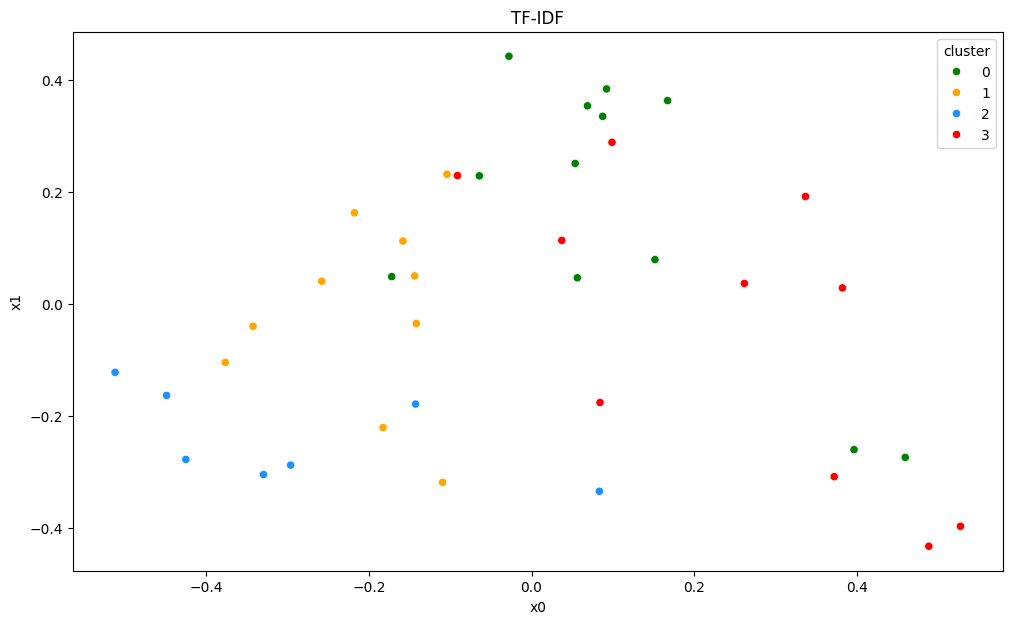

0.6666666666666666
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       1.00      0.50      0.67         4
           2       0.50      1.00      0.67         1
           3       0.67      0.67      0.67         3

    accuracy                           0.67        12
   macro avg       0.69      0.73      0.67        12
weighted avg       0.74      0.67      0.67        12



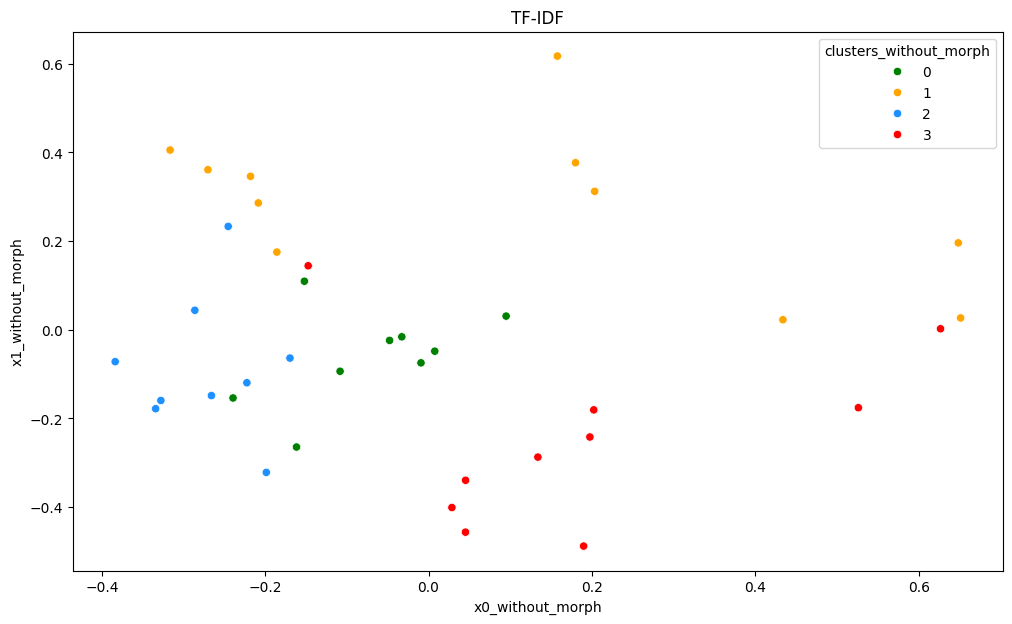

0.75
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.60      1.00      0.75         3
           2       0.50      0.50      0.50         2
           3       1.00      0.67      0.80         3

    accuracy                           0.75        12
   macro avg       0.78      0.73      0.73        12
weighted avg       0.82      0.75      0.76        12



In [41]:
dfDescriptions["formated"] = dfDescriptions.text.apply(
    lambda textFTale: get_normal_form_str(format_data(textFTale))
)
dfDescriptions["formated_without_morph"] = dfDescriptions.text.apply(
    lambda textFTale: format_data(textFTale)
)

def _getVectorizer(fieldName):
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    x = vectorizer.fit_transform(dfDescriptions[fieldName])
    return x

def _getClusters(x, fieldName):
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(x)
    clusters = kmeans.labels_
    dfDescriptions[fieldName] = clusters

def _pca(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    dfDescriptions[fieldX0] = x0
    dfDescriptions[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(
        data=dfDescriptions, 
        x=fieldX0, 
        y=fieldX1, 
        hue=fieldCluster, 
        palette=['green', 'orange', 'dodgerblue', 'red']
    )
    plt.show()

def _calcAccuracy(x, fieldCluster):
    XVectorDf = pd.DataFrame(x.toarray())
    xTraining, xTest, yTraining, yTest = train_test_split(
        XVectorDf, 
        dfDescriptions[fieldCluster], 
        test_size=0.3,
        random_state=42
    )

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processTfIdf(fieldData, fieldCluster, fieldX0, fieldX1):
    X = _getVectorizer(fieldData)
    _getClusters(X, fieldCluster)
    _pca(X, fieldX0, fieldX1, fieldCluster)
    _calcAccuracy(X, fieldCluster)

processTfIdf('formated', 'cluster', "x0", "x1")
processTfIdf('formated_without_morph', 'clusters_without_morph', "x0_without_morph", "x1_without_morph")


#### Векторизация текстов с использованием метода Word2Vec

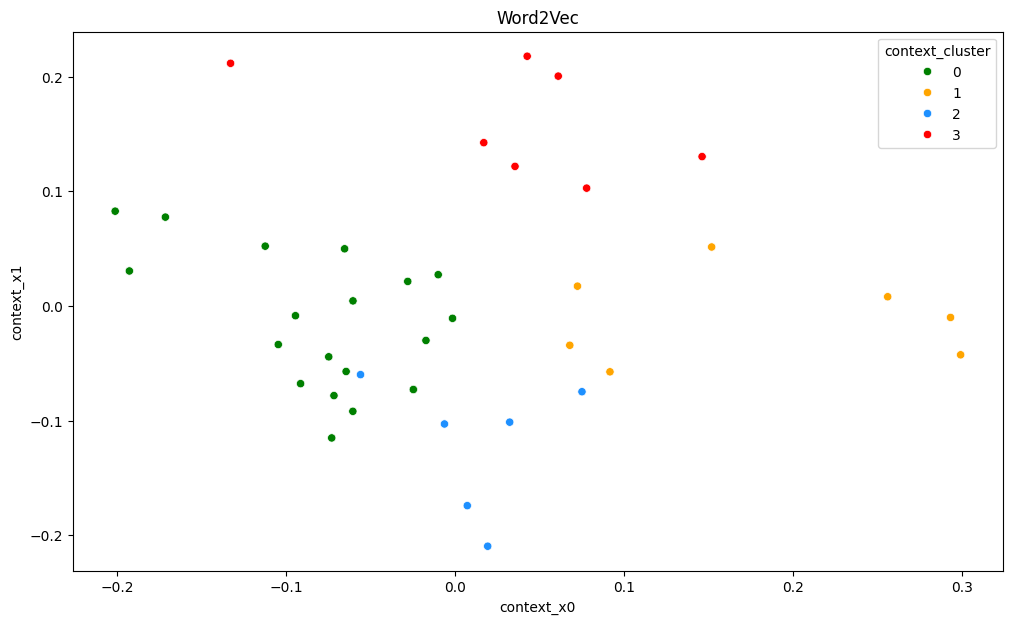

0.9166666666666666
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.96      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



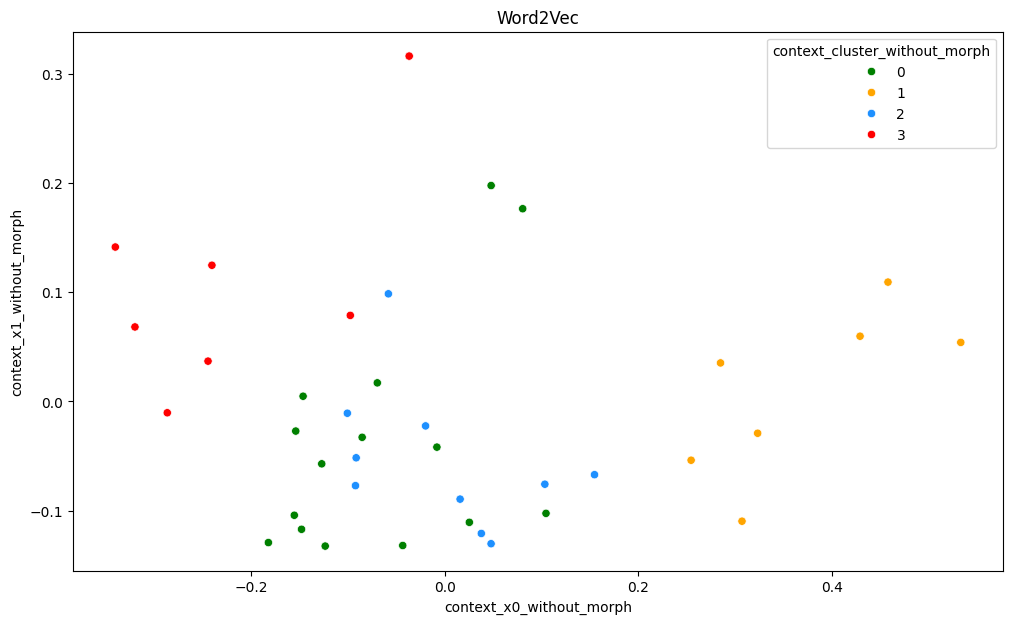

0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         3
           2       0.50      0.50      0.50         2
           3       0.67      1.00      0.80         2

    accuracy                           0.83        12
   macro avg       0.79      0.82      0.80        12
weighted avg       0.86      0.83      0.84        12



,num_doc,text,class,formated,formated_without_morph,cluster,x0,x1,clusters_without_morph,x0_without_morph,x1_without_morph,context_cluster,context_x0,context_x1,context_cluster_without_morph,context_x0_without_morph,context_x1_without_morph
0,1,Прошедший матч был настоящим шедевром футбольн...,football,прошедший матч настоящий шедевр футбольный иск...,прошедший матч настоящим шедевром футбольного ...,1,-0.258001,0.041293,2,-0.265821,-0.148406,0,-0.094608,-0.008475,2,-0.100593,-0.010795
1,2,В этом поединке встретились две команды с разн...,football,поединок встретиться команда разный стиль игра...,поединке встретились две команды разными стиля...,1,-0.376682,-0.103857,2,-0.286136,0.044017,2,0.019128,-0.209554,0,-0.127058,-0.057122
2,3,Этот матч был насыщен событиями с самого начал...,football,матч насыщенный событие начало финальный свист...,матч насыщен событиями самого начала финальног...,2,-0.425121,-0.277158,2,-0.198643,-0.321638,2,0.032145,-0.101337,2,0.047869,-0.130276
3,4,Этот матч был истинным испытанием для обеих ко...,football,матч истинный испытание оба команда каждый игр...,матч истинным испытанием обеих команд каждый и...,2,-0.296226,-0.287227,3,0.045186,-0.456448,3,0.035297,0.121754,2,0.103415,-0.075785
4,5,В этом матче сила и техническое мастерство ста...,football,матч сила технический мастерство сталкиваться ...,матче сила техническое мастерство сталкивались...,2,-0.512195,-0.121487,2,-0.334132,-0.178004,2,-0.056106,-0.059880,2,-0.091485,-0.051606
5,6,Этот матч был насыщен атмосферой напряжения и ...,football,матч насыщенный атмосфера напряжение азарт оба...,матч насыщен атмосферой напряжения азарта обе ...,2,-0.448850,-0.162777,2,-0.327709,-0.159458,2,-0.006443,-0.102928,2,-0.092194,-0.077112
6,7,В этой встрече соперничающие команды продемонс...,football,встреча соперничать команда продемонстрировать...,встрече соперничающие команды продемонстрирова...,1,-0.109402,-0.317920,3,0.202260,-0.180661,3,0.016811,0.142449,1,0.254506,-0.053829
7,8,Этот поединок был истинным испытанием для кажд...,football,поединок истинный испытание каждый игрок поле ...,поединок истинным испытанием каждого игрока по...,0,-0.171949,0.049479,3,0.045339,-0.339444,3,-0.133009,0.211667,2,0.015877,-0.089447
8,9,Этот матч представлял собой настоящий футбольн...,football,матч представлять настоящий футбольный триллер...,матч представлял собой настоящий футбольный тр...,2,-0.329556,-0.304060,3,0.028574,-0.400899,3,0.077671,0.102784,2,0.037801,-0.120891
9,10,В этой встрече футбольные гении соперничали за...,football,встреча футбольный гений соперничать превосход...,встрече футбольные гении соперничали превосход...,1,-0.158180,0.113051,0,-0.009276,-0.074578,0,-0.201285,0.082693,2,-0.058206,0.098549


In [42]:
def _get_w2vdf(fieldData):
    w2v_df = pd.DataFrame(dfDescriptions[fieldData]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df

def _train_w2v(w2v_df):
    w2v_model = Word2Vec(min_count=1, vector_size=100)
    
    w2v_model.build_vocab(w2v_df)
    w2v_model.train(w2v_df, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
    return w2v_model

def _preprocess(s):
    return [i for i in s.split()]

def _get_vector(s, model):
    return np.sum(np.array([model.wv[i] for i in _preprocess(s)]), axis=0)

def _pcaContext(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    dfDescriptions[fieldX0] = x0
    dfDescriptions[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("Word2Vec")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(
        data=dfDescriptions, 
        x=fieldX0, 
        y=fieldX1, 
        hue=fieldCluster, 
        palette=['green', 'orange', 'dodgerblue', 'red']
    )
    plt.show()

def _calcAccuracyContext(x, fieldCluster):
    XVectorDf = pd.DataFrame(x)
    xTraining, xTest, yTraining, yTest = train_test_split(
        XVectorDf, 
        dfDescriptions[fieldCluster], 
        test_size=0.3, 
        random_state=42
    )

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processContex(fieldData, fieldCluster, fieldX0, fieldX1):
    w2v_df = _get_w2vdf(fieldData)
    w2v_model = _train_w2v(w2v_df)

    x = [_get_vector(text, w2v_model) for text in dfDescriptions[fieldData]]
    x = normalize(x)

    _getClusters(x, fieldCluster)
    _pcaContext(x, fieldX0, fieldX1, fieldCluster)
    _calcAccuracyContext(x, fieldCluster)

processContex("formated", "context_cluster", "context_x0", "context_x1")
processContex("formated_without_morph", "context_cluster_without_morph", "context_x0_without_morph", "context_x1_without_morph")

dfDescriptions